# 7 一般化線型混合モデル(GLMM)

実際のデータ解析でよく遭遇する「GLMではうまく説明できない」現象をうまく扱えるようにGLMを強化

一般化線型モデル(GLM)は確率分布・リンク関数・線型予測子を組み合わせて応答変数$y_i$と説明変数$x_i$を関連づけるシステム。
ただし、単純なGLMでは現実のデータ解析に応用できない。

例えば植物個体の種子数の調査を行うとする。説明変数がどの個体でも同じ値だったとする。
「観測された個体差」である説明変数に違いないのであれば、どの個体の種子数も同じ平均$\lambda$のポアソン分布に従うはず。
しかし、現実の生物では「説明変数以外は全部均質」といった条件は満たされないでしょうから、平均$\lambda$の値が全個体共通とはならない。

そのため、説明変数が同じであるなら平均も同じというGLMの過程が成立しないため、集団全体の種子数の分布はポアソン分布で期待されるよりも大きくばらつく。
「個体間の差異」が定量化できない。しかし「何か原因不明な個体差がある」ことは統計モデルとして表現できる。

「人間が測定できない・測定しなかった個体差」を組み込んだGLMのことを一般化線型混合モデル(generalized linser mixed model: GLMM)という。
データのばらつきは二項分布・ポアソン分布で、個体のばらつきは正規分布で表すような複数の確率分布を部品とする統計モデル。

## 7.1 例題: GLMでは説明できないカウントデータ

種子生存数の問題。
葉数とともにどのように増大するかを解明するのが目的。

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
# ダークモードの場合、設定しないとメモリが見えなくなる
plt.style.use('dark_background')

import seaborn as sns
import numpy as np

import statsmodels.formula.api as smf
from scipy.stats import poisson,binom
import math

# https://github.com/aviatesk/intro-statistical-modeling/edit/master/data/data7.csv
data7 = pd.read_csv('../data/data7.csv')
data7.describe()


,N,y,x,id
count,100.0,100.000000,100.000000,100.000000
mean,8.0,3.810000,4.000000,50.500000
std,0.0,3.070534,1.421338,29.011492
min,8.0,0.000000,2.000000,1.000000
25%,8.0,1.000000,3.000000,25.750000
50%,8.0,3.000000,4.000000,50.500000
75%,8.0,7.000000,5.000000,75.250000
max,8.0,8.000000,6.000000,100.000000


<AxesSubplot:xlabel='x', ylabel='y'>

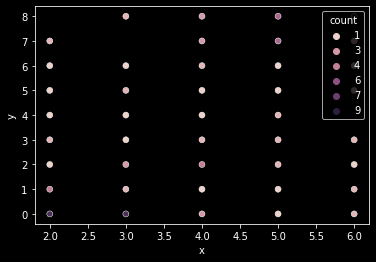

In [14]:
data7_grouped = data7.drop(["N", "id"], axis=1).groupby(['x', 'y']).size().to_frame('count').reset_index()
sns.scatterplot(x='x', y='y', hue="count", data=data7_grouped)

GLMを使ってデータから種子の生存確率を推定してみる。
線型予測子とロジットリンク関数を使って、生存確率を$q_i$とすると

$logit(q_i) = \beta_1 + \beta_2 x_i$

とする。観測された生存種子数が$y_i$である確率が二項分布に従うとすると

$p(y_i| \beta_1, \beta_2) = \begin{pmatrix} 8 \\ y_i \end{pmatrix} q_i^{y_i}(1-q_i)^{8-y_i}$

となる。全個体の対数尤度は

$logL=\sum_i log p(y_i|\beta_1,\beta_2)$

となる。このlogLが最大となる切片$\beta_1, \beta_2$をみつけるのがこの統計の最尤推定。

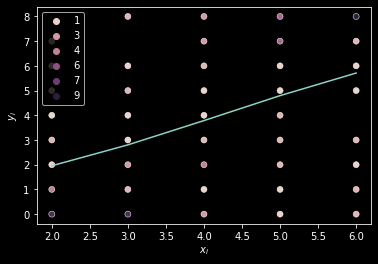

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -322.80
Date:                Wed, 06 Jan 2021   Deviance:                       513.84
Time:                        16:44:57   Pearson chi2:                     428.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1487      0.237     -9.057      0.000      -2.614      -1.684
x              0.5104      0.056      9.179      0.000       0.401       0.619
==============================================================================
"""

In [18]:
import statsmodels.api as sm
fit = smf.glm(formula='y + I(N - y) ~ x', data=data7, family=sm.families.Binomial())
res_fit = fit.fit()
fig = plt.figure()
ax = fig.add_subplot(111)
sns.scatterplot(x='x', y='y', hue="count", data=data7_grouped)
x_list = np.arange(2, 7, 1)
y_list = res_fit.predict(exog = pd.DataFrame({'x': x_list}))
# y_listは生存確率なのでNの8をかける
ax.plot(x_list, y_list * 8)
ax.set_xlabel('$x_i$')
ax.set_ylabel('$y_i$')
ax.legend()
plt.show()

res_fit.summary()

$\hat{\beta_1}=-2.14, \hat{\beta_2}=0.51$となっている。

だが、真の傾きは$\beta_2=1$らしい。
ここでつくったものは二項分布に従っている感じではないっぽい

## 7.2 過分散と個体差

N個の種子のうちy個が生存したというカウントデータを使っているのにそのばらつきが二項分布で説明できないように見える。
にもかかわらずむりやり二項分布であると仮定したモデルを無理やりに当て嵌めたので正しい推定値が得られなかった。
このように二項分布で期待されるよりも大きなばらつきを過分散(over dispersion)という

### 7.2.1 過分散: ばらつきが多すぎる